In [1]:
import pandas as pd
import copy
import numpy as np
from tensorflow.keras.models import Sequential, load_model
from scipy.stats import pearsonr, spearmanr
from scipy.special import logit
import matplotlib.pyplot as plt
from matplotlib import rcParams
import matplotlib
rcParams.update({'figure.autolayout': True})
rcParams['svg.fonttype'] = 'none'
rcParams['font.size']=10

In [2]:
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False),
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

In [3]:
celltypelist = ["Astro",
                "L2.3.IT",
                "L5.6.NP",
                "L5.ET",
                "L5.IT",
                "L6b",
                "L6.CT",
                "L6.IT",
                "LAMP5",
                "Micro.PVM",
                "Oligo",
                "OPC",
                "PVALB",
                "SST",
                "VIP"]

In [4]:
def identify_model_cell_type(celltypelist, model_file_name):
    for celltype in celltypelist:
        if celltype in model_file_name:
            return celltype

In [5]:
model_file_names = dict()
for celltype in celltypelist:
    model_file_names[celltype] = []

file_names_file = "/projects/pfenninggroup/singleCell/BICCN_human_M1_SNARE-Seq2/ArchR_analyses/ml_models/cnn/eramamur_additional_files/best_cnn_model_file_names.txt"
with open(file_names_file, 'r') as f:
    for line in f:
        model_file_name = line.strip()
        celltype = identify_model_cell_type(celltypelist, model_file_name)
        model_file_names[celltype].append(model_file_name)

In [6]:
def switch_g_c_channels(seq_array):
    g_channel = copy.deepcopy(seq_array[:,:,1])
    c_channel = copy.deepcopy(seq_array[:,:,2])
    seq_array[:,:,1] = c_channel
    seq_array[:,:,2] = g_channel
    seq_array = np.expand_dims(seq_array, axis=3)
    return seq_array

In [7]:
snigdha_ad_ref_sequences = np.load("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ad_variants_processing/ref_501bp_sequences.npy")
snigdha_ad_alt_sequences = np.load("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ad_variants_processing/alt_501bp_sequences.npy")

In [8]:
snigdha_ad_ref_sequences = switch_g_c_channels(snigdha_ad_ref_sequences)
snigdha_ad_alt_sequences = switch_g_c_channels(snigdha_ad_alt_sequences)

In [10]:
snp_data = pd.read_csv("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ad_variants_processing/snigdha_snp_list_unique_haploreg_hg19_positions_1kb_and_500bp_sequences_microglia_monocyte_neuron_bulk_scores.txt",
                       sep='\t')

In [14]:
for celltype in celltypelist:
    for i,modelfile in enumerate(model_file_names[celltype]):
        model = load_model(modelfile, compile=False)
        ad_snps_ref_sequences_scores = model.predict(snigdha_ad_ref_sequences)
        ad_snps_alt_sequences_scores = model.predict(snigdha_ad_alt_sequences)
        ad_snps_score = logit(ad_snps_ref_sequences_scores)-logit(ad_snps_alt_sequences_scores)
        ad_snps_score = (ad_snps_score)/np.std(ad_snps_score)
        snp_data["_".join([celltype,"fold",str(i+1),"ref","score"])] = ad_snps_ref_sequences_scores
        snp_data["_".join([celltype,"fold",str(i+1),"alt","score"])] = ad_snps_alt_sequences_scores
        snp_data["_".join([celltype,"fold",str(i+1),"score"])] = ad_snps_score

(0.5670588598477109, 8.421950907940482e-104)
SpearmanrResult(correlation=0.503773880787624, pvalue=8.511827478413399e-79)


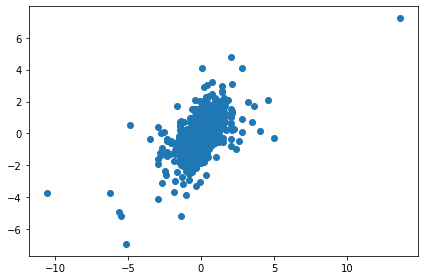

In [20]:
plt.scatter(snp_data["microglia_regression_effect_score"], snp_data["Micro.PVM_fold_1_score"])
print(pearsonr(snp_data["microglia_regression_effect_score"], snp_data["Micro.PVM_fold_1_score"]))
print(spearmanr(snp_data["microglia_regression_effect_score"], snp_data["Micro.PVM_fold_1_score"]))

(0.31830181479708053, 7.191914287990975e-30)
SpearmanrResult(correlation=0.2567698053845888, pvalue=1.1756575147191571e-19)


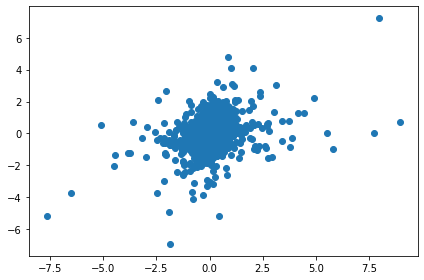

In [21]:
plt.scatter(snp_data["monocyte_regression_effect_score"], snp_data["Micro.PVM_fold_1_score"])
print(pearsonr(snp_data["monocyte_regression_effect_score"], snp_data["Micro.PVM_fold_1_score"]))
print(spearmanr(snp_data["monocyte_regression_effect_score"], snp_data["Micro.PVM_fold_1_score"]))

(0.1285757483067896, 7.302766840014076e-06)
SpearmanrResult(correlation=0.08347783131152621, pvalue=0.00367664848882622)


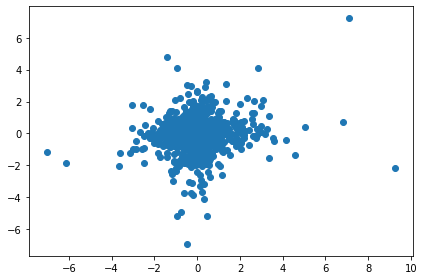

In [22]:
plt.scatter(snp_data["neuron_regression_effect_score"], snp_data["Micro.PVM_fold_1_score"])
print(pearsonr(snp_data["neuron_regression_effect_score"], snp_data["Micro.PVM_fold_1_score"]))
print(spearmanr(snp_data["neuron_regression_effect_score"], snp_data["Micro.PVM_fold_1_score"]))

(0.3342948947894314, 5.94500270684281e-33)
SpearmanrResult(correlation=0.22580604264688106, pvalue=1.923914490464116e-15)


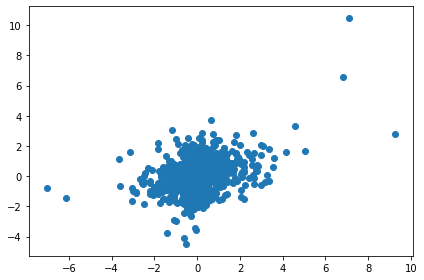

In [26]:
plt.scatter(snp_data["neuron_regression_effect_score"], snp_data["L2.3.IT_fold_1_score"])
print(pearsonr(snp_data["neuron_regression_effect_score"], snp_data["L2.3.IT_fold_1_score"]))
print(spearmanr(snp_data["neuron_regression_effect_score"], snp_data["L2.3.IT_fold_1_score"]))

(0.3544722053492945, 4.12927307936155e-37)
SpearmanrResult(correlation=0.2707781963043147, pvalue=9.243757489540309e-22)


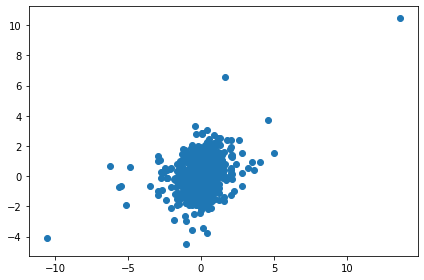

In [27]:
plt.scatter(snp_data["microglia_regression_effect_score"], snp_data["L2.3.IT_fold_1_score"])
print(pearsonr(snp_data["microglia_regression_effect_score"], snp_data["L2.3.IT_fold_1_score"]))
print(spearmanr(snp_data["microglia_regression_effect_score"], snp_data["L2.3.IT_fold_1_score"]))

In [28]:
snp_data.to_csv("/projects/pfenninggroup/machineLearningForComputationalBiology/eramamur_stuff/ad_variants_processing/snigdha_snp_list_unique_haploreg_hg19_positions_1kb_and_500bp_sequences_microglia_monocyte_neuron_bulk_scores_and_biccn_classifiers_scores.txt",
                 sep='\t',
                 header=True,
                 index=False)